In [1]:
import os
import time
import copy
import json
import random

import argparse
import math as m
import matplotlib
from random import randrange

import tensorflow as tf


import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from segysak.segy import segy_loader
from typing import Union

2024-04-02 11:35:31.134933: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 11:35:31.134968: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 11:35:31.134993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 11:35:31.141140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
# change alpha values
color_array[:, -1] = 0
color_array[255] = [0., 0., 1., 1.]

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='filter', colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

color_array[255] = [1., 0., 0., 1.]
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='label', colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

color_array[255] = [0., 1., 0., 1.]
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='cpixel', colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

/tmp/ipykernel_13046/2145889905.py:12: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object)
/tmp/ipykernel_13046/2145889905.py:19: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object)
/tmp/ipykernel_13046/2145889905.py:26: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object)


In [3]:
def direction(iline_direction: np.ndarray):
    """ Calculates the angle between the given vector and the referential vector (1.,0.).

    :param iline_direction: The two dimentional array which angle will be calculated.

    :return: Return de the angle between the vector(1.,0.) and iline_direction in degrees.
    """
    a = np.array([1., 0.])
    b = iline_direction
    sin_th1 = np.cross(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    cos_th1 = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    degree = np.rad2deg(np.arctan2(sin_th1, cos_th1))

    if degree < 0:
        degree += 360

    return degree


def compass_card(iline_direction: np.ndarray):
    """ Gives the closest cardinal direction to which a vector is pointing.

    :param iline_direction: The two dimentional array which cardinal direction will be returned.

    :return: A Tuple of str which are the origin of the closest cardinal direction and where it is pointed.
    """
    degree = direction(iline_direction)

    e = 0.
    e_2 = 360
    w = 180.
    n = 90.
    s = 270.

    ne = (n + e) / 2
    nw = (n + w) / 2
    se = (s + e_2) / 2
    sw = (s + w) / 2

    CC = [e, ne, n, nw, w, sw, s, se]
    CC_names = ['E', 'NE', 'N', 'NW',
                'W', 'SW', 'S', 'SE']
    min_degree = 360
    min_pos = -1
    for i, cc in enumerate(CC):
        dist_degree = abs(cc - degree)
        if min_degree > dist_degree:
            min_degree = dist_degree
            min_pos = i

    if (e_2 - degree) < min_degree:  # case for fourth quadrant near E
        min_pos = 0

    return CC_names[(min_pos + 4) % 8], CC_names[min_pos]



def plot_2D_visualization(segy_cube, inference_cube, output_path: str,
                          slice_beg: int, slice_end: int, gas: Union[str, dict] = ''):
    """ Saves the plot for 2D visualizations.

    :param segy_cube: The opened segy file cube with the seismic data.
    :param inference_cube: The opened segy file cube with the inference data.
    :param output_path: The path that the file will be saved.
    :param slice_beg: The beginning of the range of the time slice which the plot will be made.
    :param slice_end: The end of the range of the time slice which the plot will be made.
    :param roi: The .json file or dictionary containing the roi data.
    :param gas: The .json file or dictionary containing the gas data.
    """

    if isinstance(gas, str):
        if gas == '':
            gas_data = {}

        else:
            with open(gas, 'r') as f:
                gas_data = json.load(f)
    elif isinstance(gas, dict):
        gas_data = gas

    fig, ax = plt.subplots(ncols=1, figsize=(12, 4), dpi=200, sharey=True, constrained_layout=True)

    crosslineX = segy_cube['cdp_x']
    crosslineY = segy_cube['cdp_y']

    iline_direction = np.array([float(crosslineX[-1] - crosslineX[0]), float(crosslineY[-1] - crosslineY[0])])

    orig, dest = compass_card(iline_direction)

    if slice_beg == -1 or slice_end == -1:
        colorbar = plt.colorbar(segy_cube.data.transpose("twt", "cdp", transpose_coords=True
                                                         ).plot(yincrease=False, cmap="Greys", add_colorbar=False))

        if inference_cube is not None:
            colorbar2 = plt.colorbar(inference_cube.data.transpose("twt", "cdp", transpose_coords=True
                                                                   ).plot(yincrease=False, cmap="cpixel",
                                                                          add_colorbar=False))

    else:
        colorbar = plt.colorbar(segy_cube.data.transpose("twt", "cdp", transpose_coords=True).sel(
            twt=slice(slice_beg, slice_end)
        ).plot(yincrease=False, cmap="Greys", add_colorbar=False), anchor=(1.5, 0))

        if inference_cube is not None:
            colorbar2 = plt.colorbar(inference_cube.data.transpose("twt", "cdp", transpose_coords=True).sel(
                twt=slice(slice_beg, slice_end)
            ).plot(yincrease=False, cmap="cpixel", add_colorbar=False))

    colorbar.set_label("Amplitude")
    if inference_cube is not None:
        colorbar2.remove()

    plt.ylabel("TWT (ms)")
    plt.xlabel("XLINE")

    if gas_data != {}:
        x_gas = [x for x, y in gas_data['gas_acumulation']]
        y_gas = [y for x, y in gas_data['gas_acumulation']]

    ax.plot(x_gas, y_gas, color="r", linewidth=2, label='Gas')
    ax.plot(0, 0, color="lime", label="ALINE Prediction")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
              fancybox=True, shadow=True, ncol=3)
    plt.text(0, slice_beg - 10, orig, fontsize=14)
    plt.text(int(0.97 * int(segy_cube['cdp'][-1])), slice_beg - 10, dest, fontsize=14)
    plt.title("Line " + segy_cube.attrs['source_file'][:-4])

    plt.savefig(output_path + segy_cube.attrs['source_file'][:-4] + '_visualization.png')



def plot_3D_visualization(segy_cube, inference_cube, output_path: str,
                          inlineNumber: int, slice_beg: int, slice_end: int,
                          roi: Union[str, dict], gas: Union[str, dict] = ''):
    """ Saves the plot for 2D visualizations.

    :param segy_cube: The opened segy file cube with the seismic data.
    :param inference_cube: The opened segy file cube with the inference data.
    :param output_path: The path that the file will be saved.
    :param inlineNumber: The inline that will be plotted.
    :param slice_beg: The beginning of the range of the time slice which the plot will be made.
    :param slice_end: The end of the range of the time slice which the plot will be made.
    :param roi: The .json file or dictionary containing the roi data.
    :param gas: The .json file or dictionary containing the gas data.

    """
    

    if isinstance(roi, str):
        if roi == '':
            roi_data = {}
        else:
            with open(roi, 'r') as f:
                roi_data = json.load(f)
    elif isinstance(roi, dict):
        roi_data = roi

    if isinstance(gas, str):
        if gas == '':
            gas_data = {}

        else:
            with open(gas, 'r') as f:
                gas_data = json.load(f)
    elif isinstance(gas, dict):
        gas_data = gas

    f, ax = plt.subplots(nrows=1, figsize=(12, 4), dpi=200, sharey=True, constrained_layout=True)
    inlineNumber = int(inlineNumber)
    for i in range(inlineNumber):
        if segy_cube['cdp_x'][i]['iline'] == inlineNumber:
            crosslineX = segy_cube['cdp_x'][i]
            crosslineY = segy_cube['cdp_y'][i]
            break

    iline_direction = np.array([float(crosslineX[-1] - crosslineX[0]), float(crosslineY[-1] - crosslineY[0])])

    orig, dest = compass_card(iline_direction)

    colorbar = plt.colorbar(segy_cube.data.transpose("twt", "iline", "xline", transpose_coords=True).sel(
        iline=inlineNumber,
        twt=slice(slice_beg, slice_end)
    ).plot(yincrease=False, cmap="Greys", add_colorbar=False))

    if inference_cube is not None:
        colorbar2 = plt.colorbar(inference_cube.data.transpose("twt", "iline", "xline", transpose_coords=True).sel(
            iline=inlineNumber,
            twt=slice(slice_beg, slice_end)
        ).plot(yincrease=False, cmap="cpixel", add_colorbar=False))

    colorbar.set_label("Amplitude")

    if inference_cube is not None:
        colorbar2.remove()
    xroitop = [x for x, y in roi_data['top_points'][str(inlineNumber)]]
    yroitop = [y for x, y in roi_data['top_points'][str(inlineNumber)]]

    xroibot = [x for x, y in roi_data['bot_points'][str(inlineNumber)]]
    yroibot = [y for x, y in roi_data['bot_points'][str(inlineNumber)]]

    if gas_data != {}:
        xgas = [x for x, y in gas_data[str(inlineNumber)]['gas_acumulation']]
        ygas = [y for x, y in gas_data[str(inlineNumber)]['gas_acumulation']]

        ax.plot(xgas, ygas, color="r", linewidth=2, label='Gas')
    #ax.plot(xroitop, yroitop, color="m", label='RoI')
    #ax.plot(xroibot, yroibot, color="m")
    ax.plot(0, 0, color="lime", label="Aline Prediction")
    ax.legend(loc="upper right")
    ax.set_title('Inline ' + str(inlineNumber))
    ax.set_xlabel("XLINE")
    ax.set_ylabel("TWT (ms)")
    #plt.text(0, slice_beg - 10, orig, fontsize=14)
    #plt.text(int(0.97 * int(xroibot[-1])), slice_beg - 10, dest, fontsize=14)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
              fancybox=True, shadow=True, ncol=3)

    plt.savefig(output_path + 'Inline_' + str(inlineNumber) + '_visualization.png')


  0%|          | 0.00/6.43k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is INLINE_3D


Converting SEGY:   0%|          | 0.00/6.43k [00:00<?, ? traces/s]

  0%|          | 0.00/8.58k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is INLINE_3D


Converting SEGY:   0%|          | 0.00/8.58k [00:00<?, ? traces/s]

IndexError: index 15 is out of bounds for axis 0 with size 15

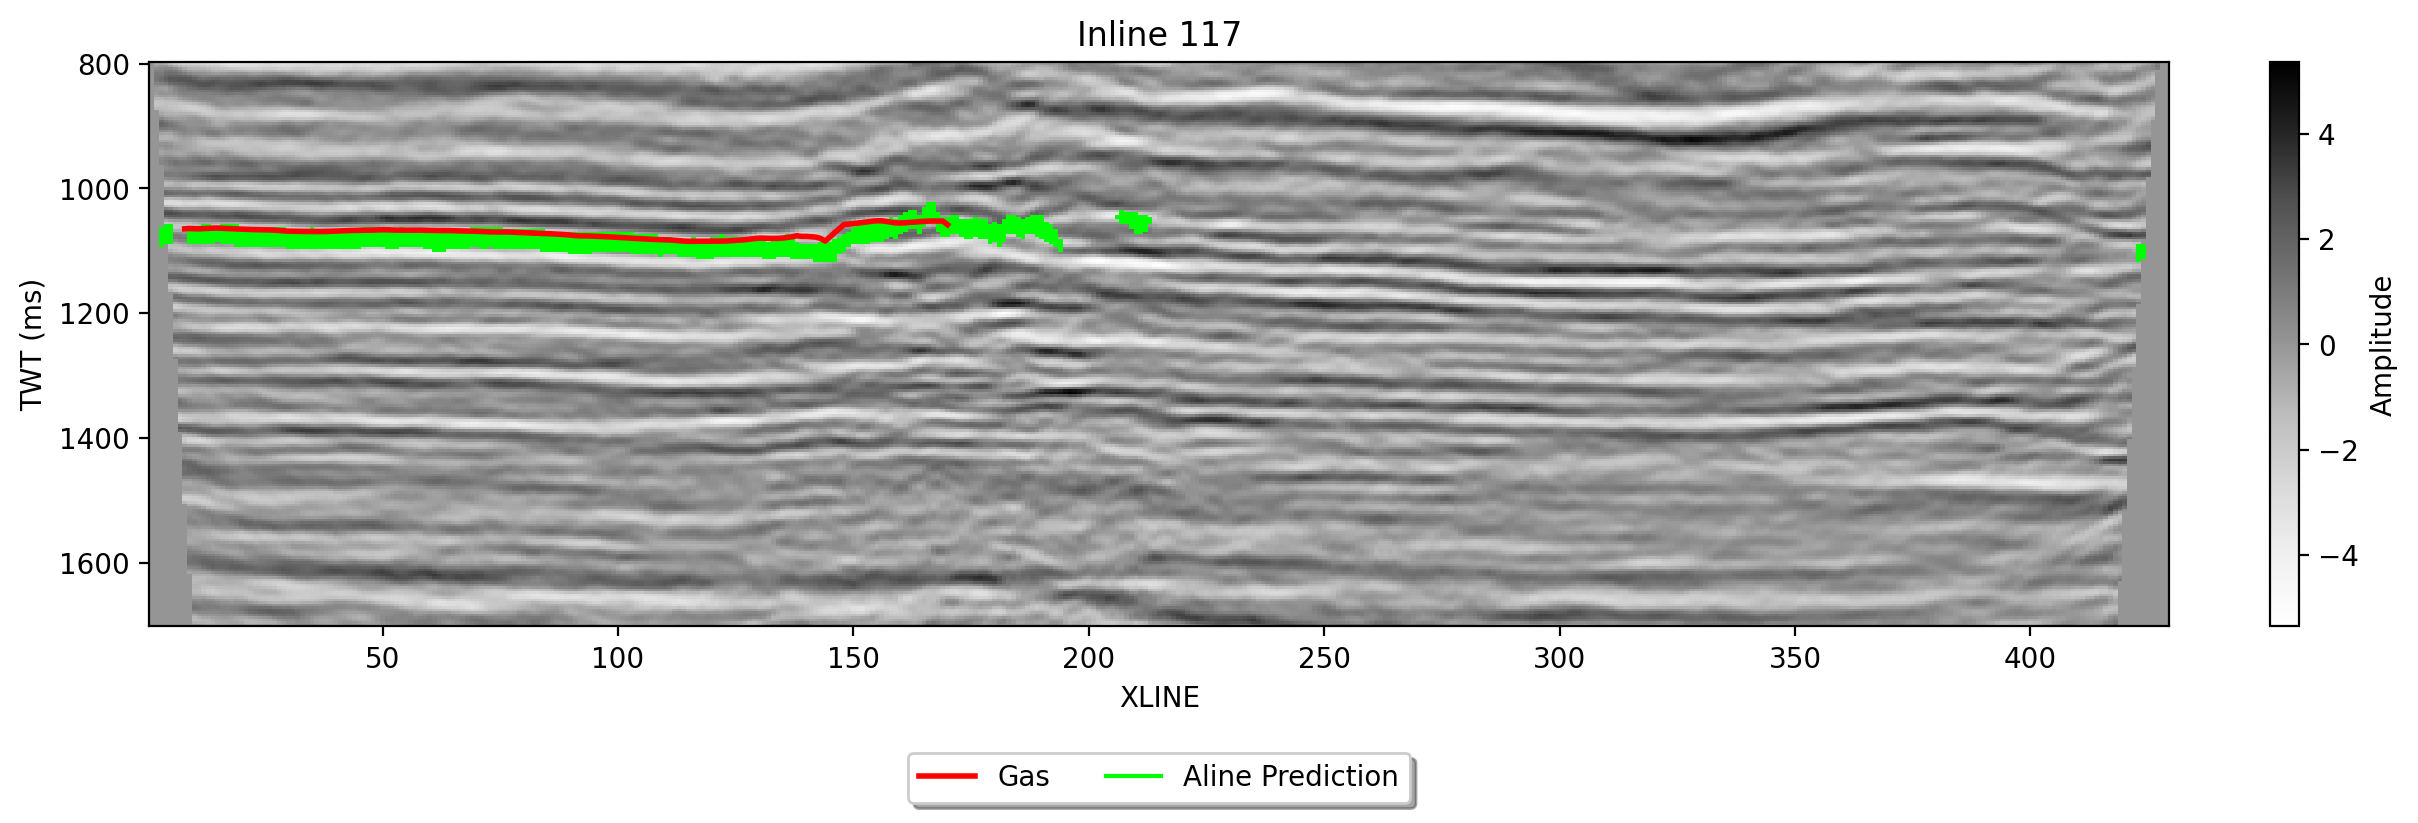

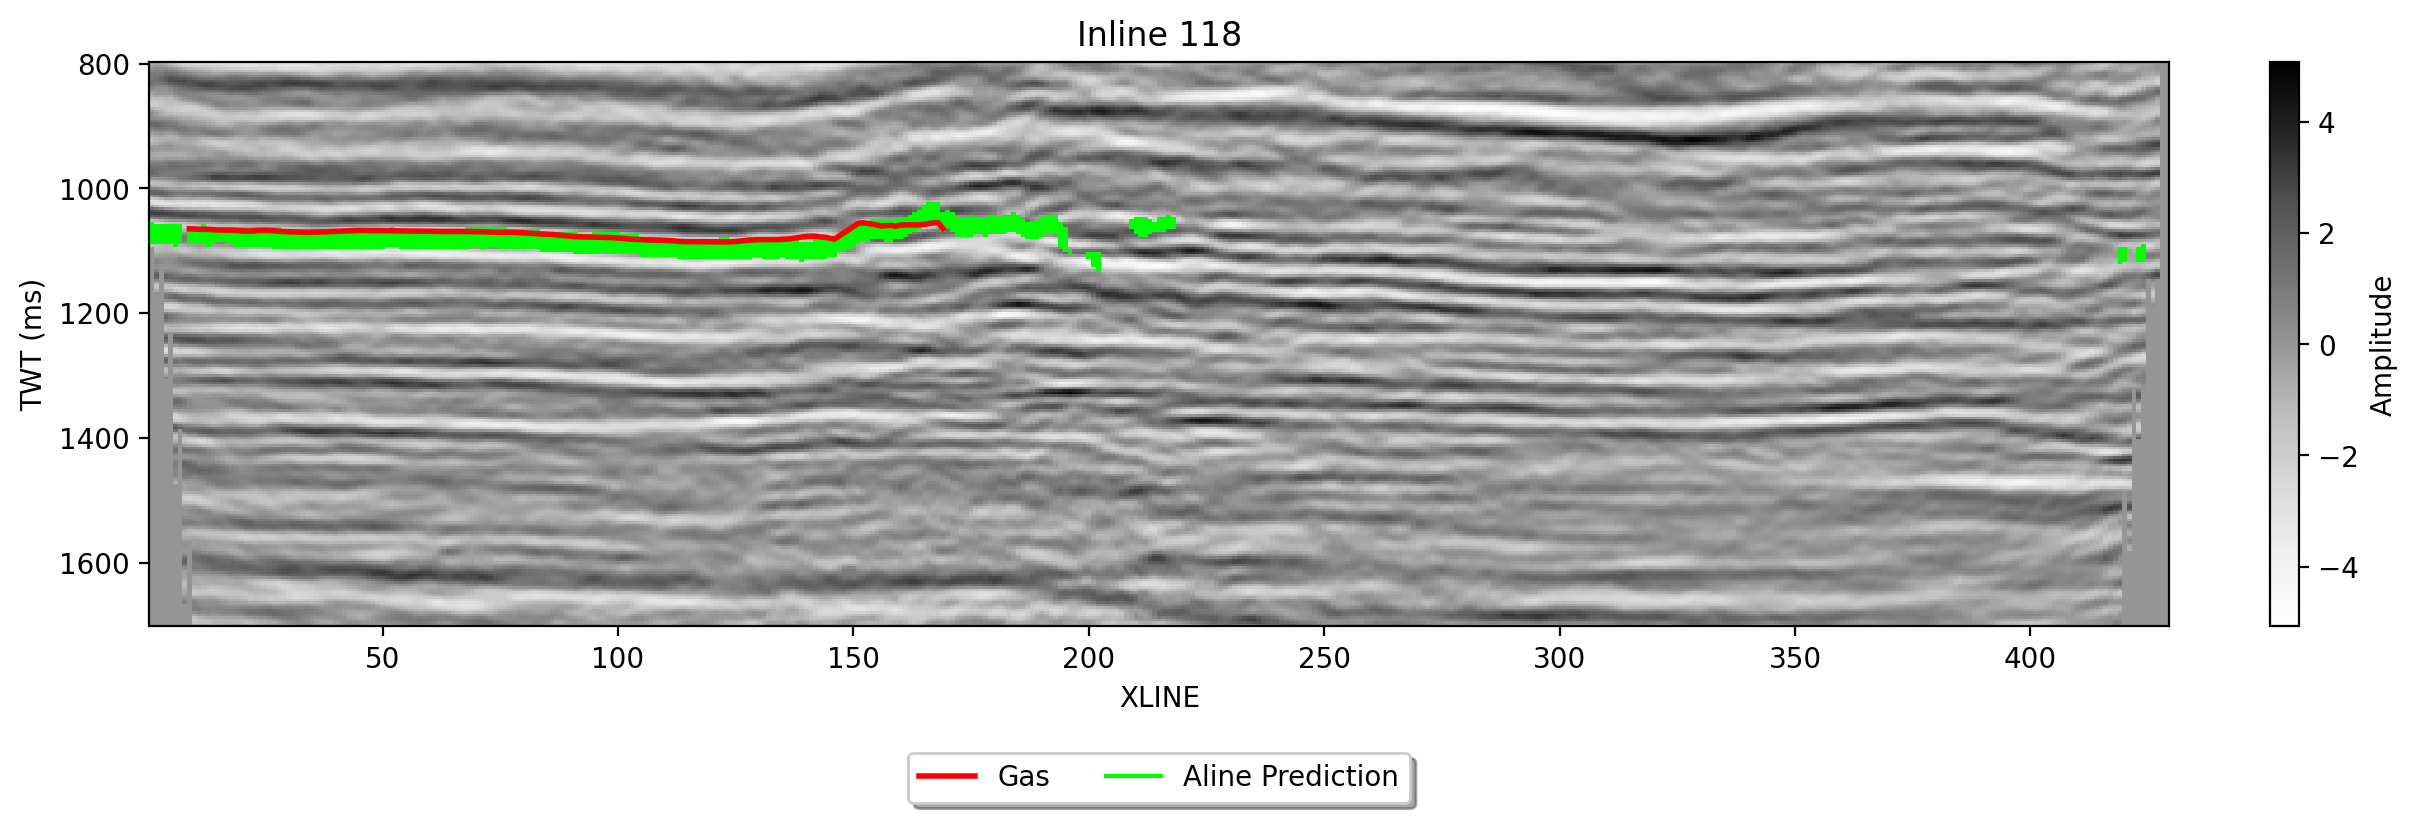

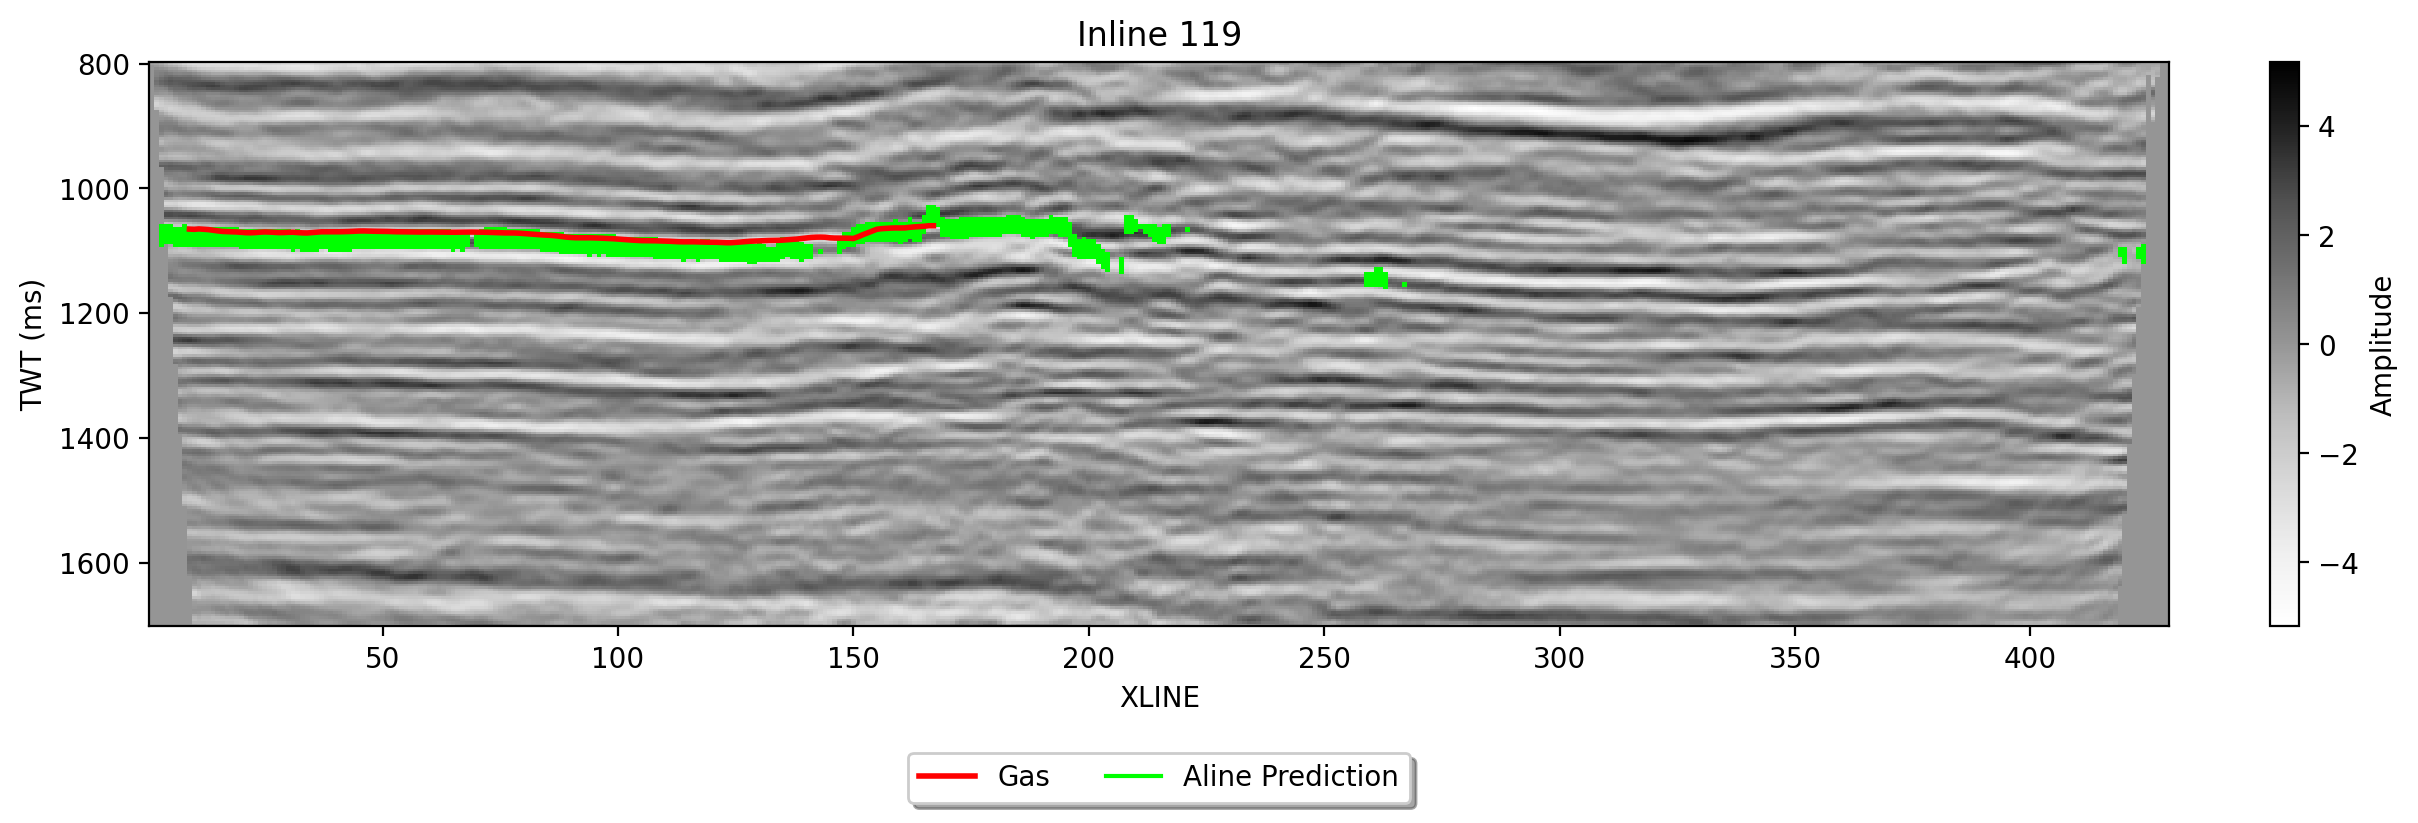

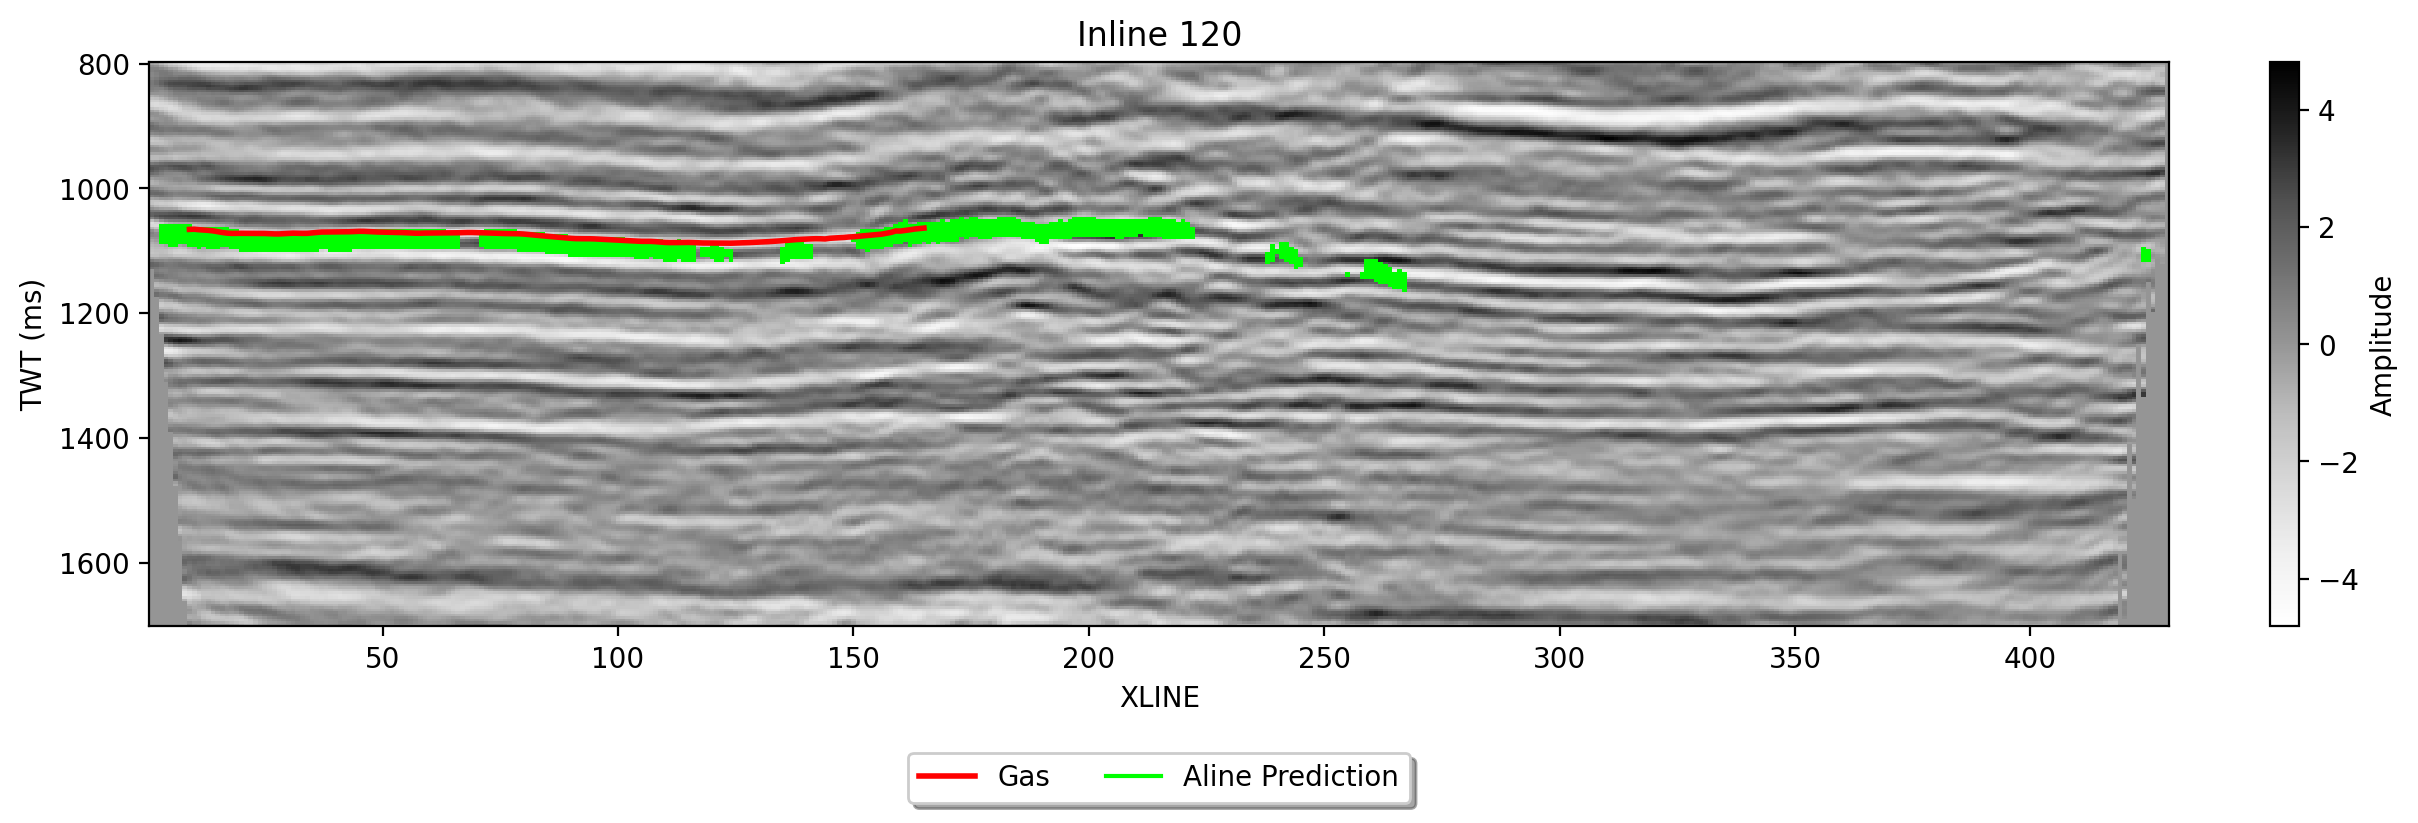

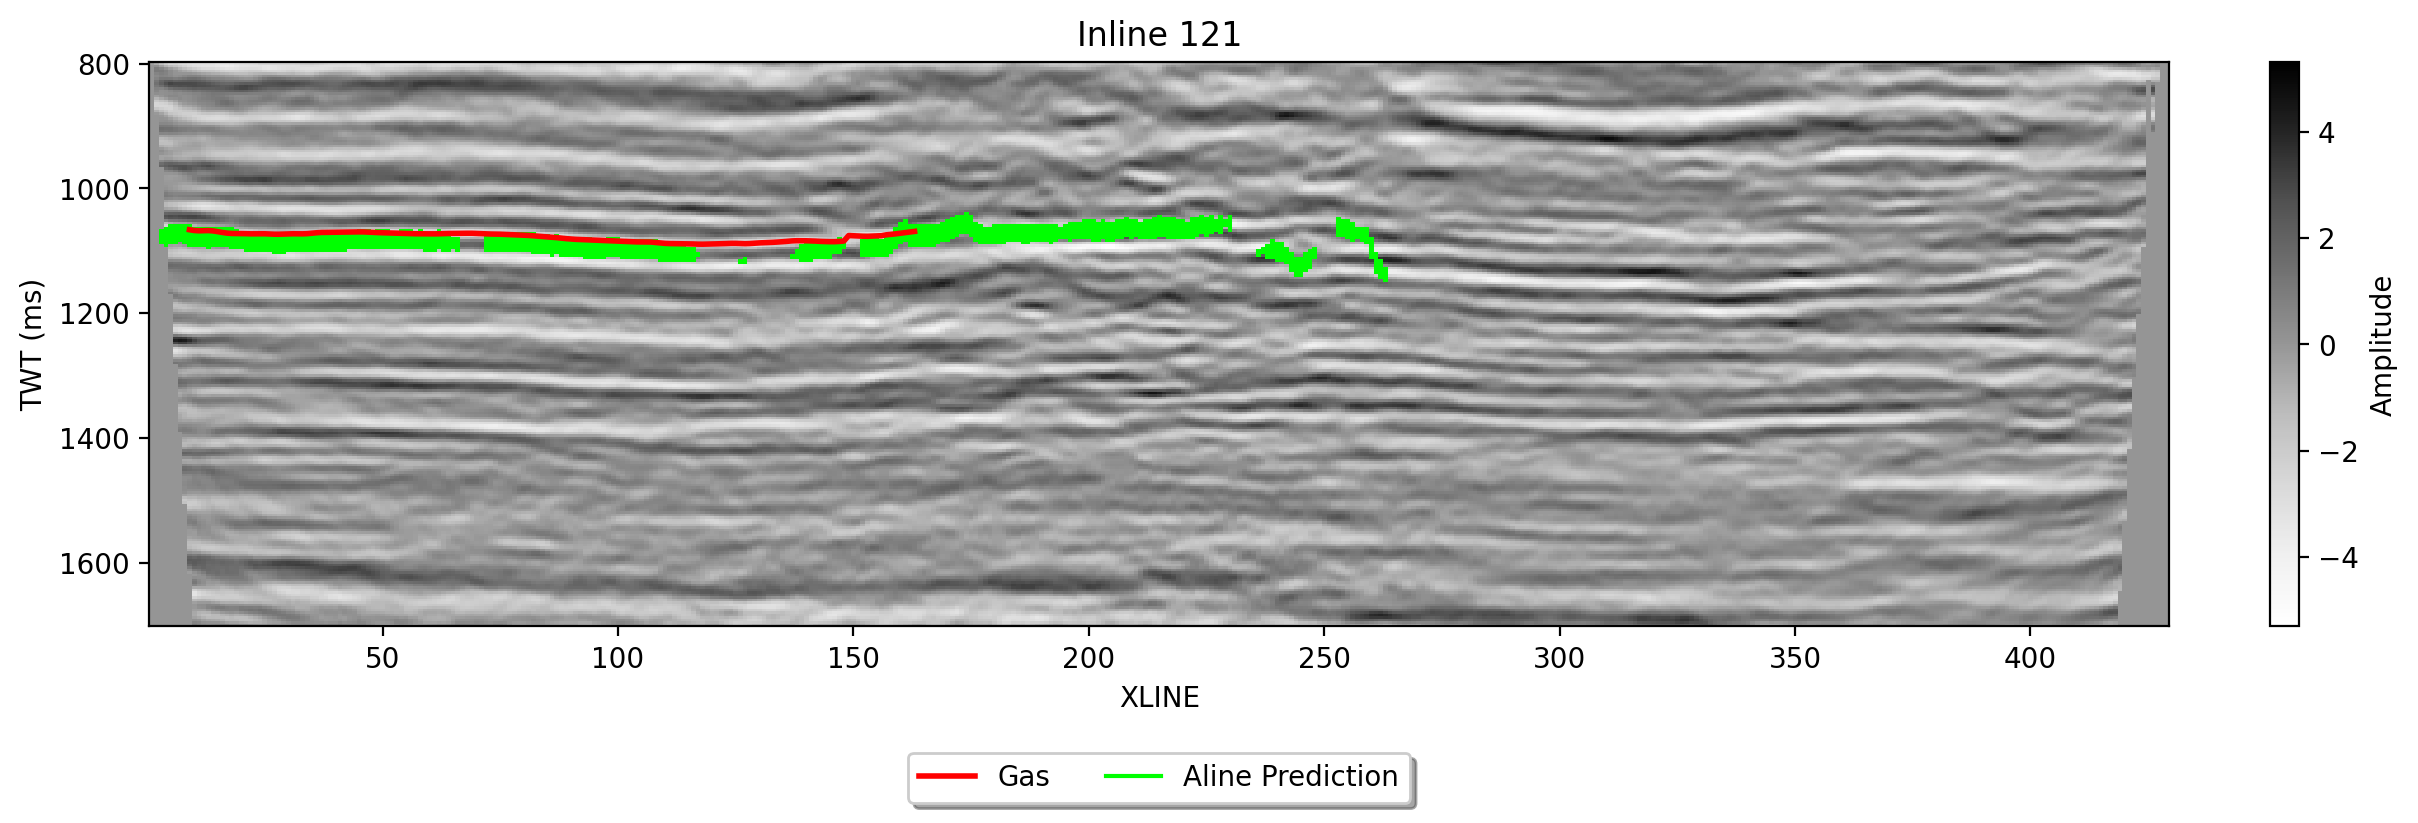

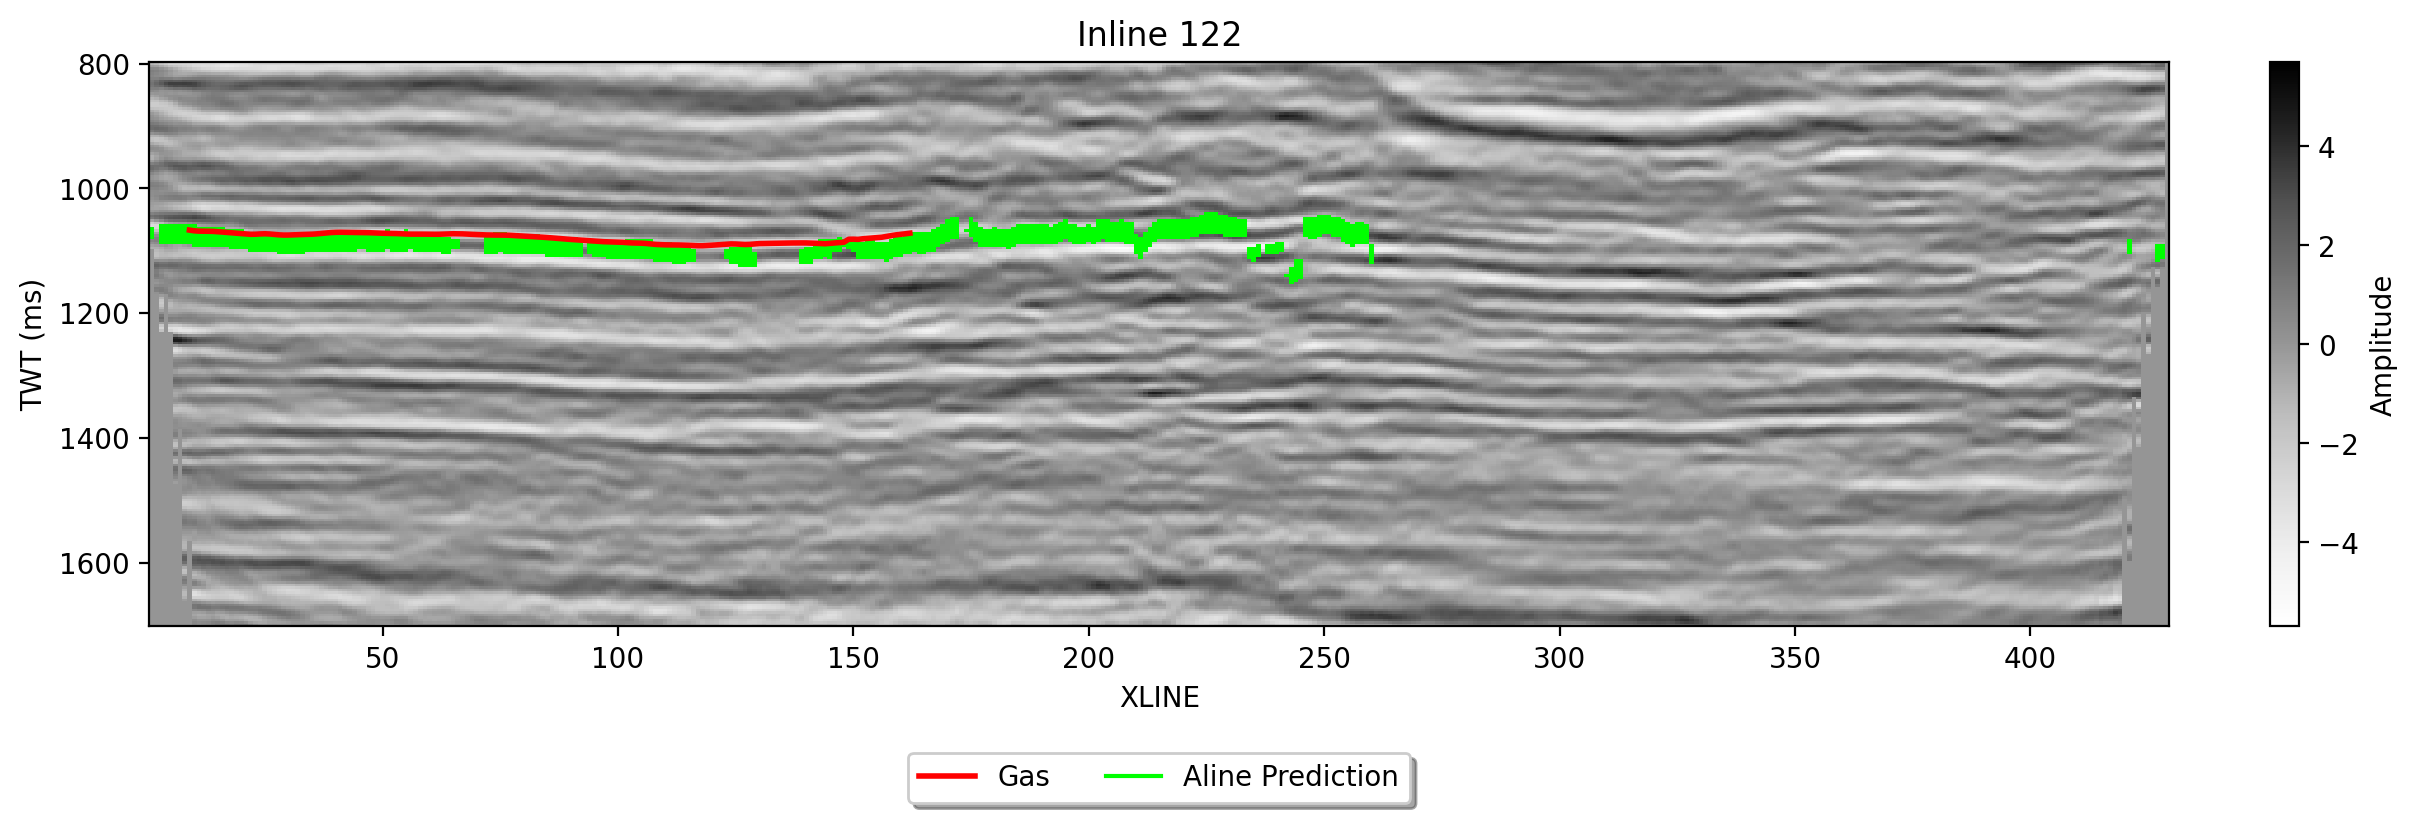

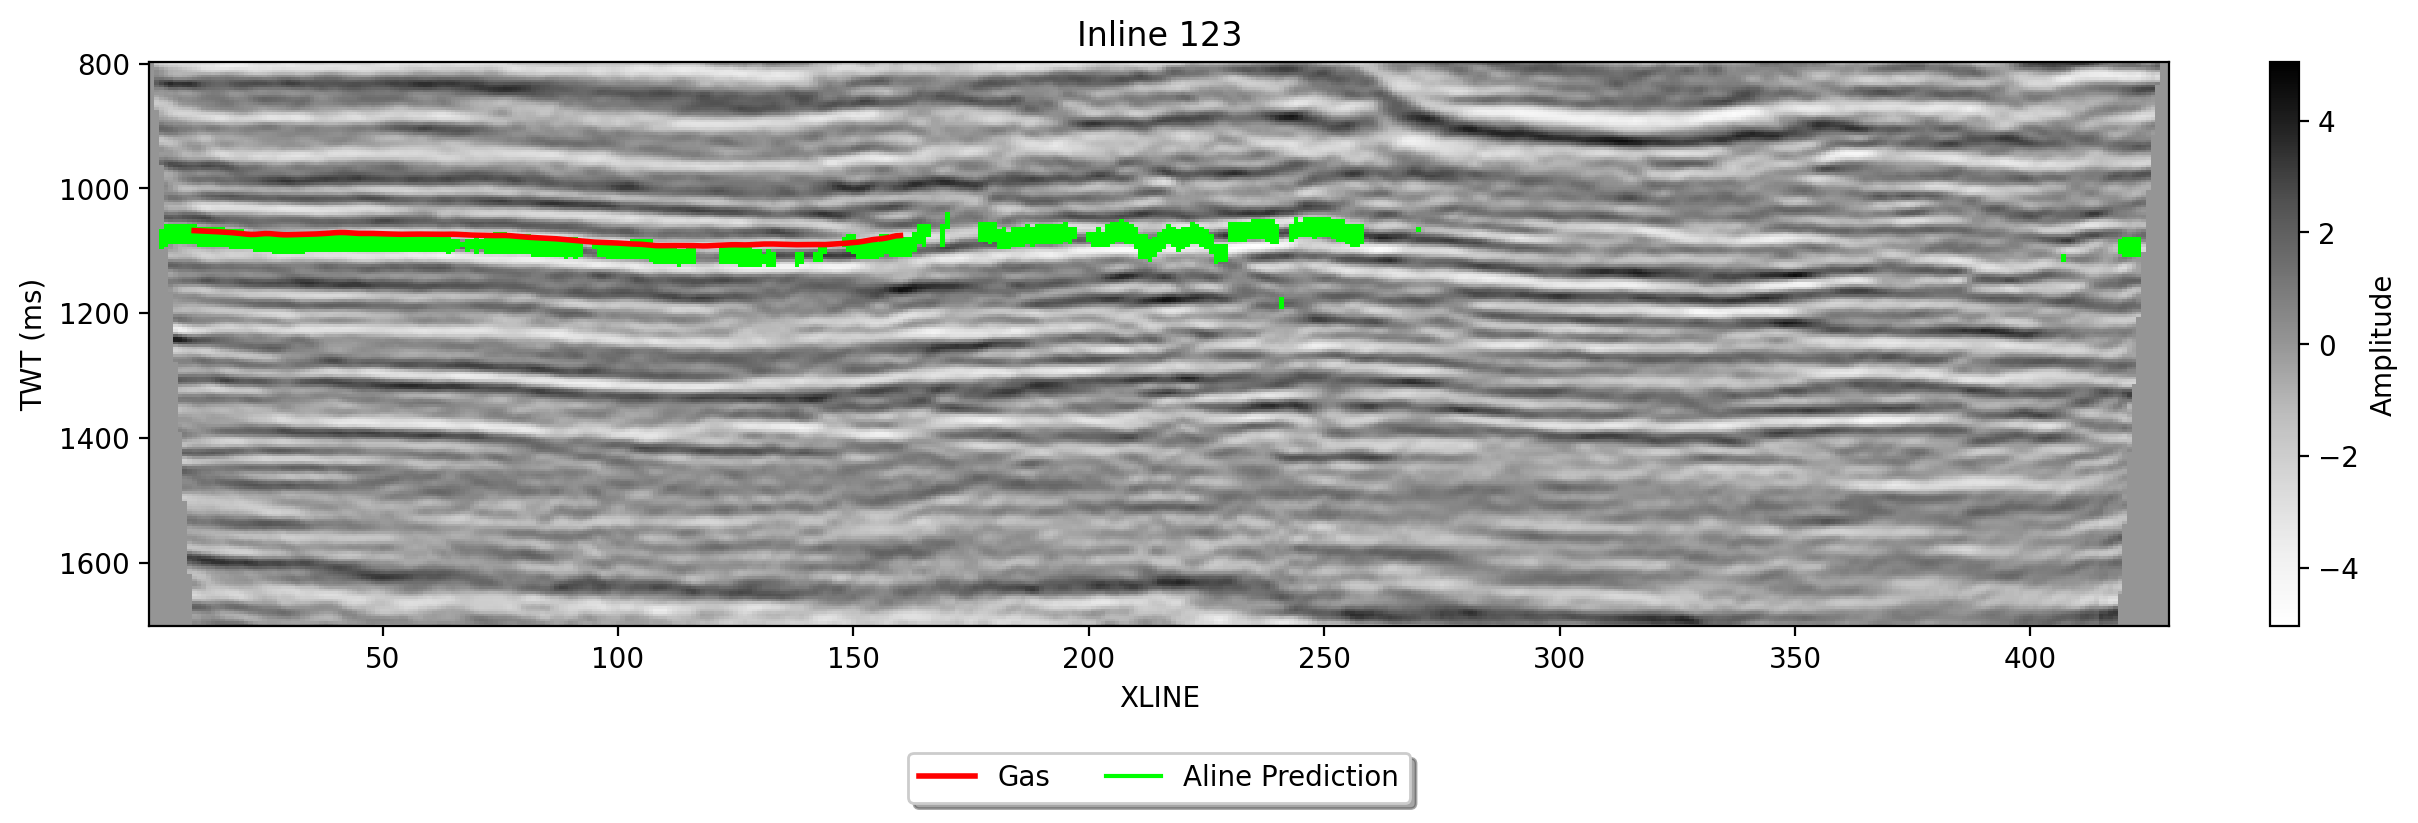

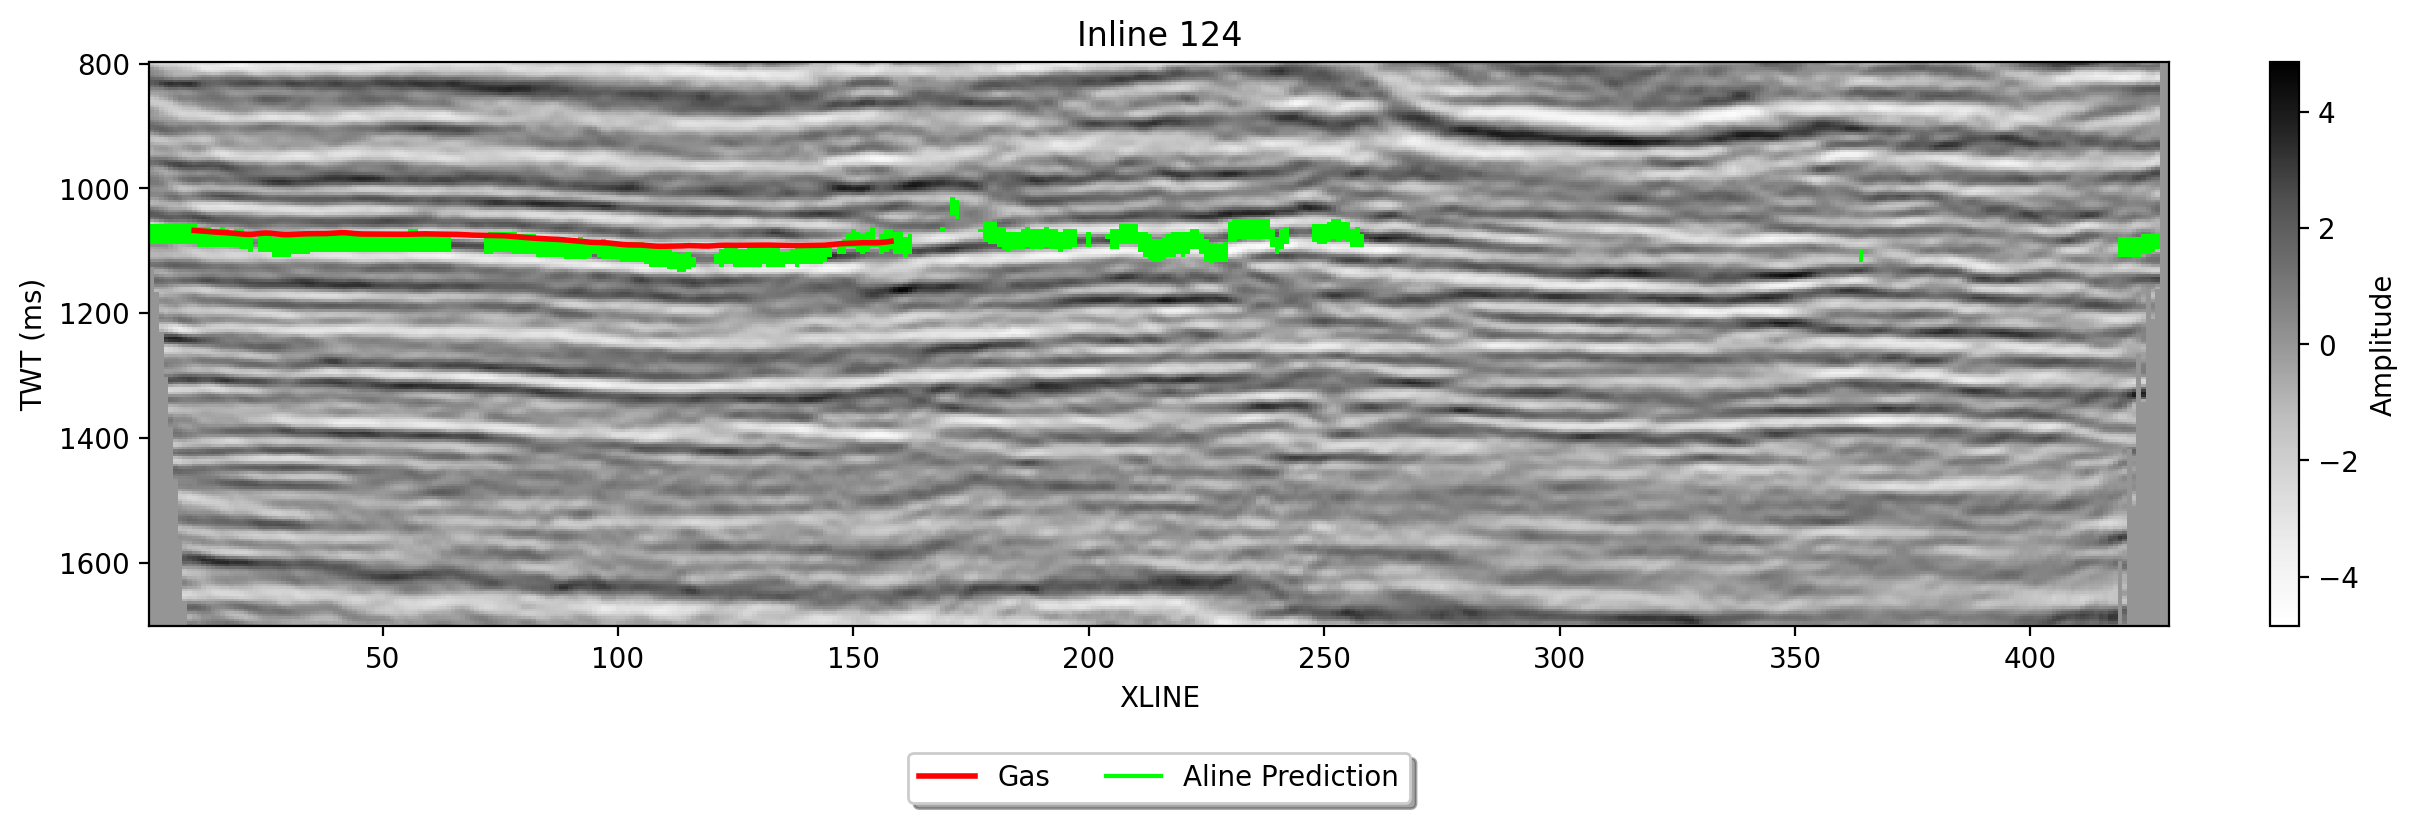

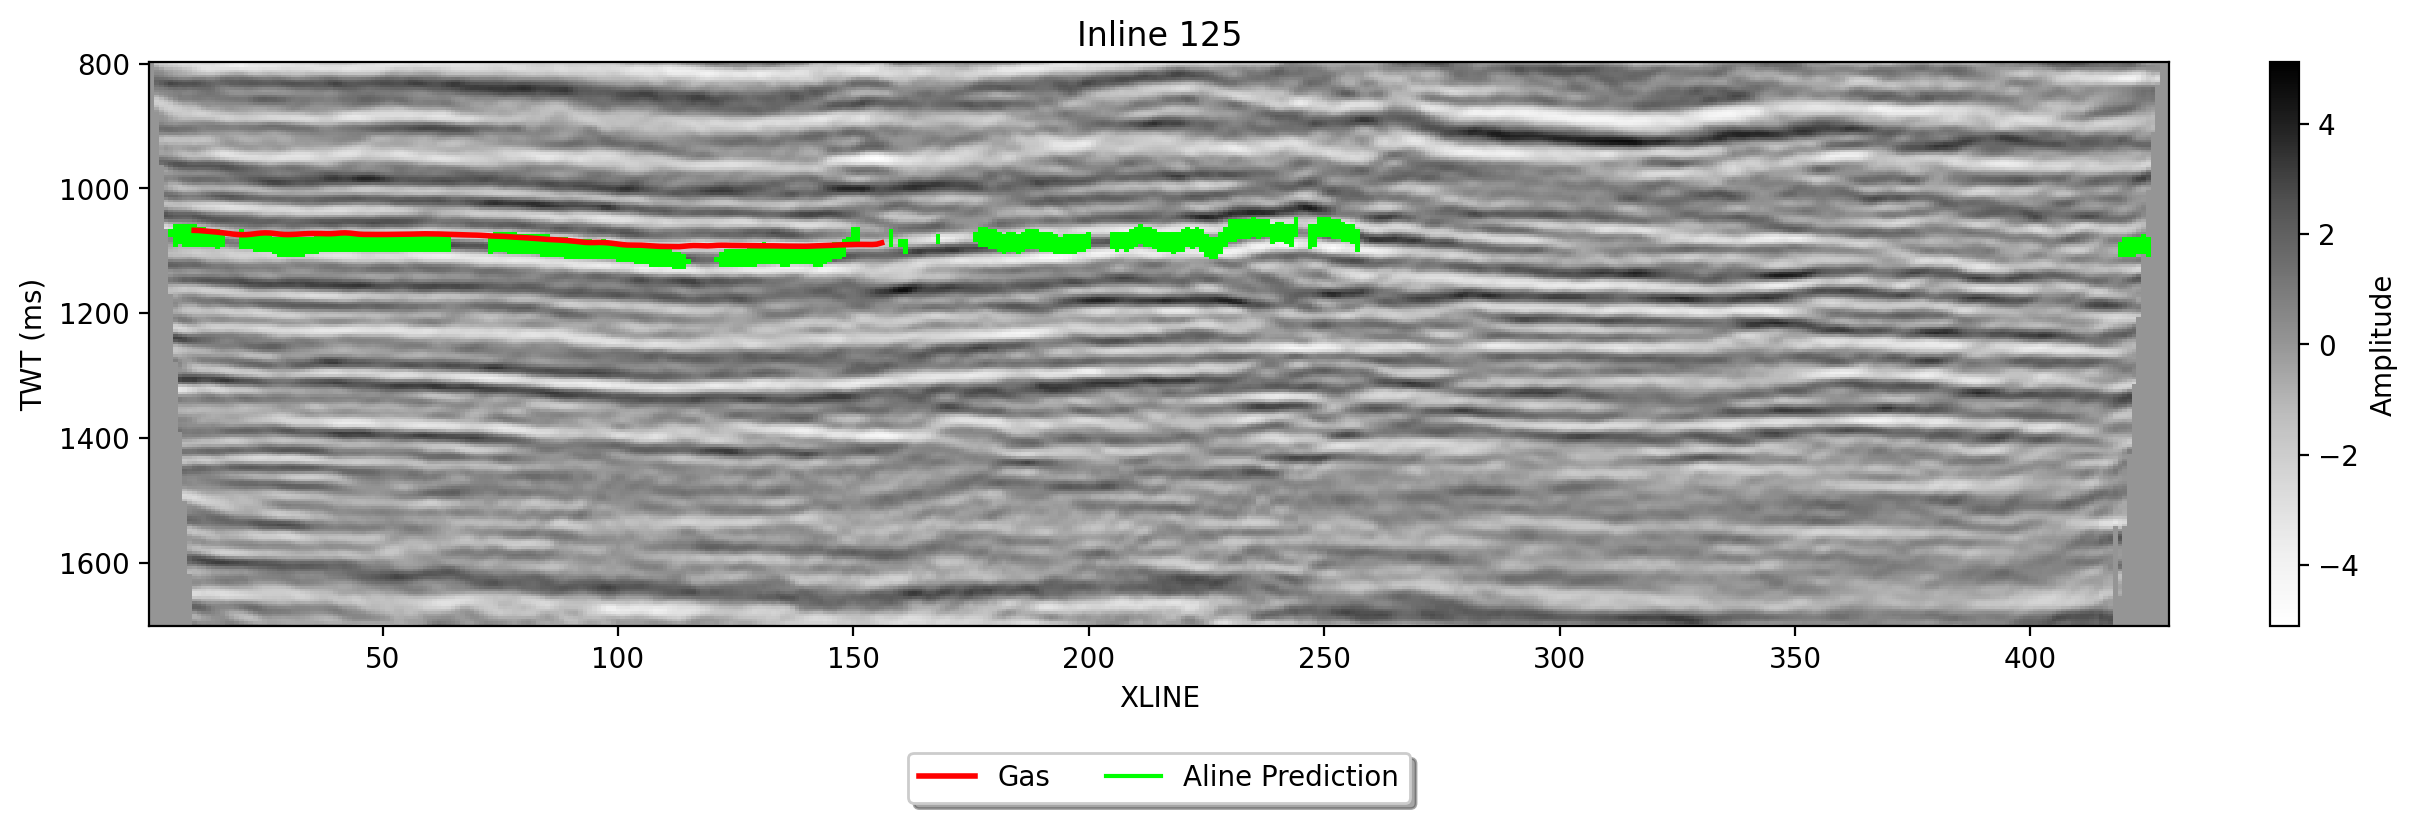

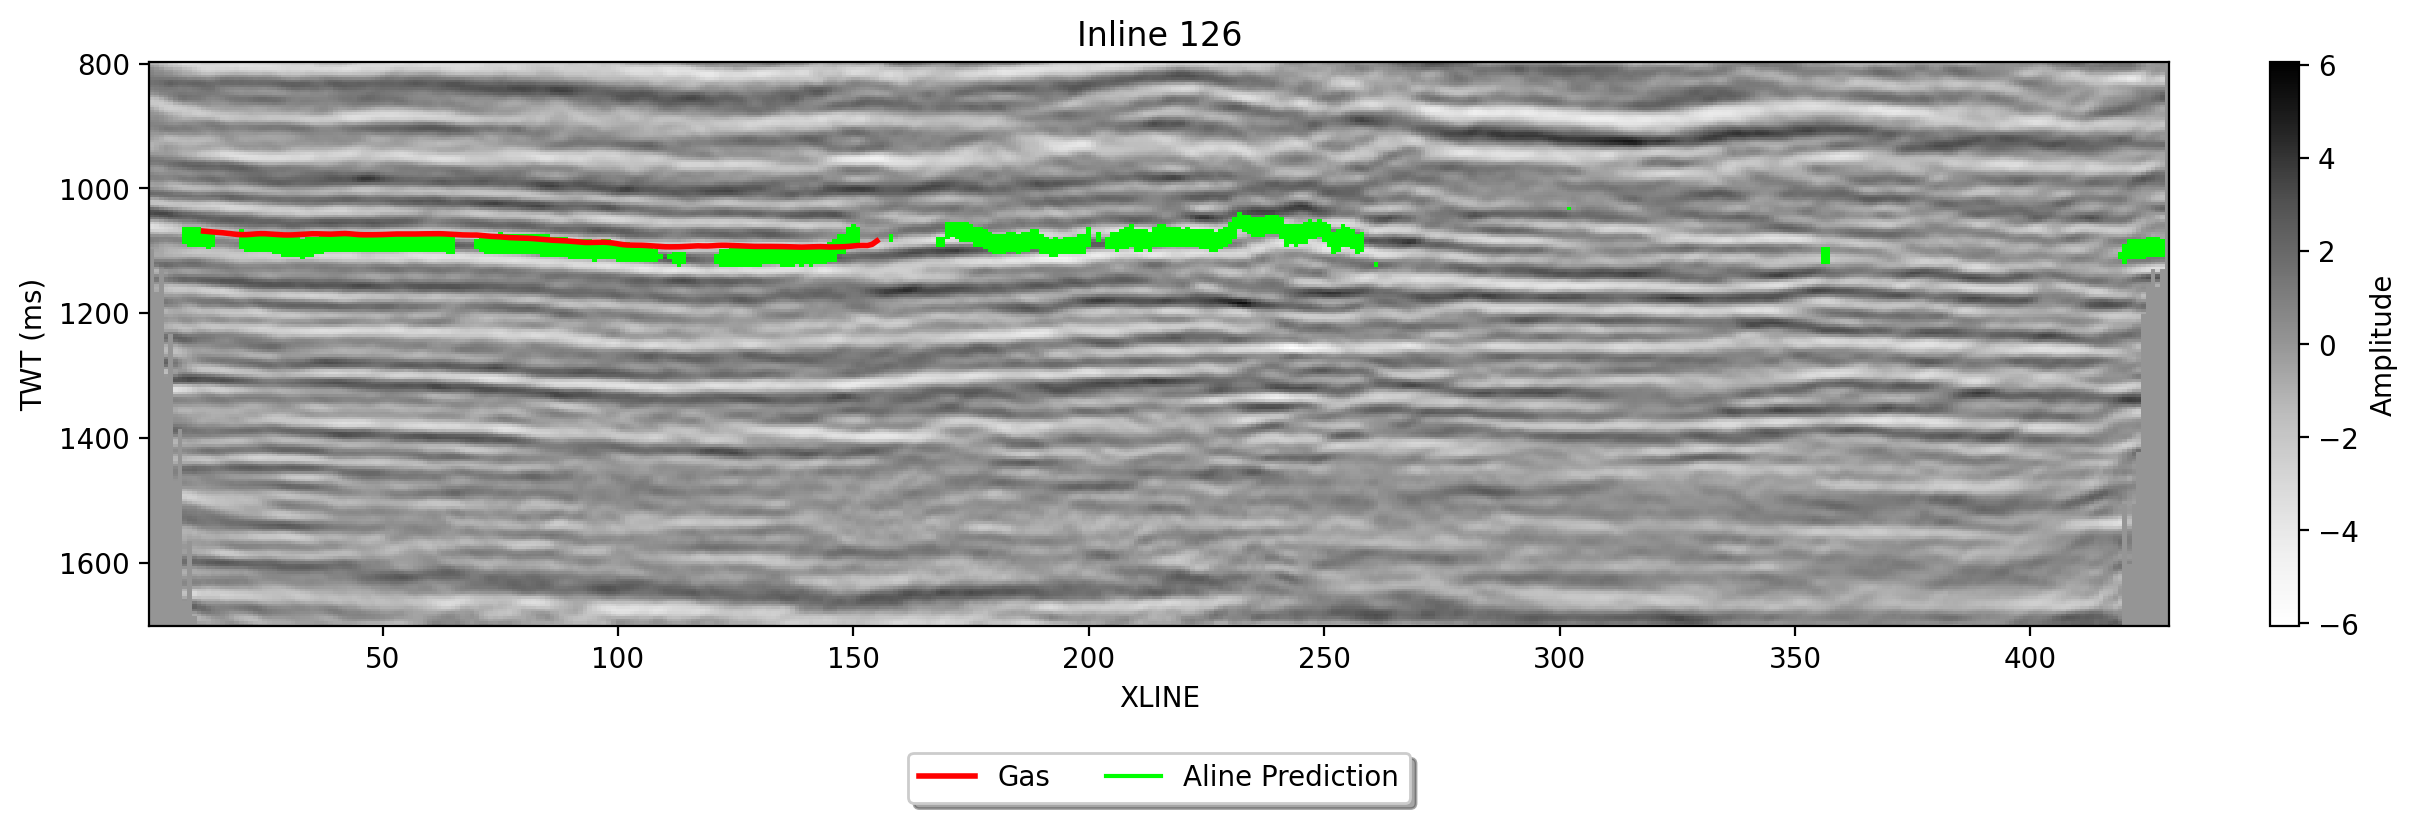

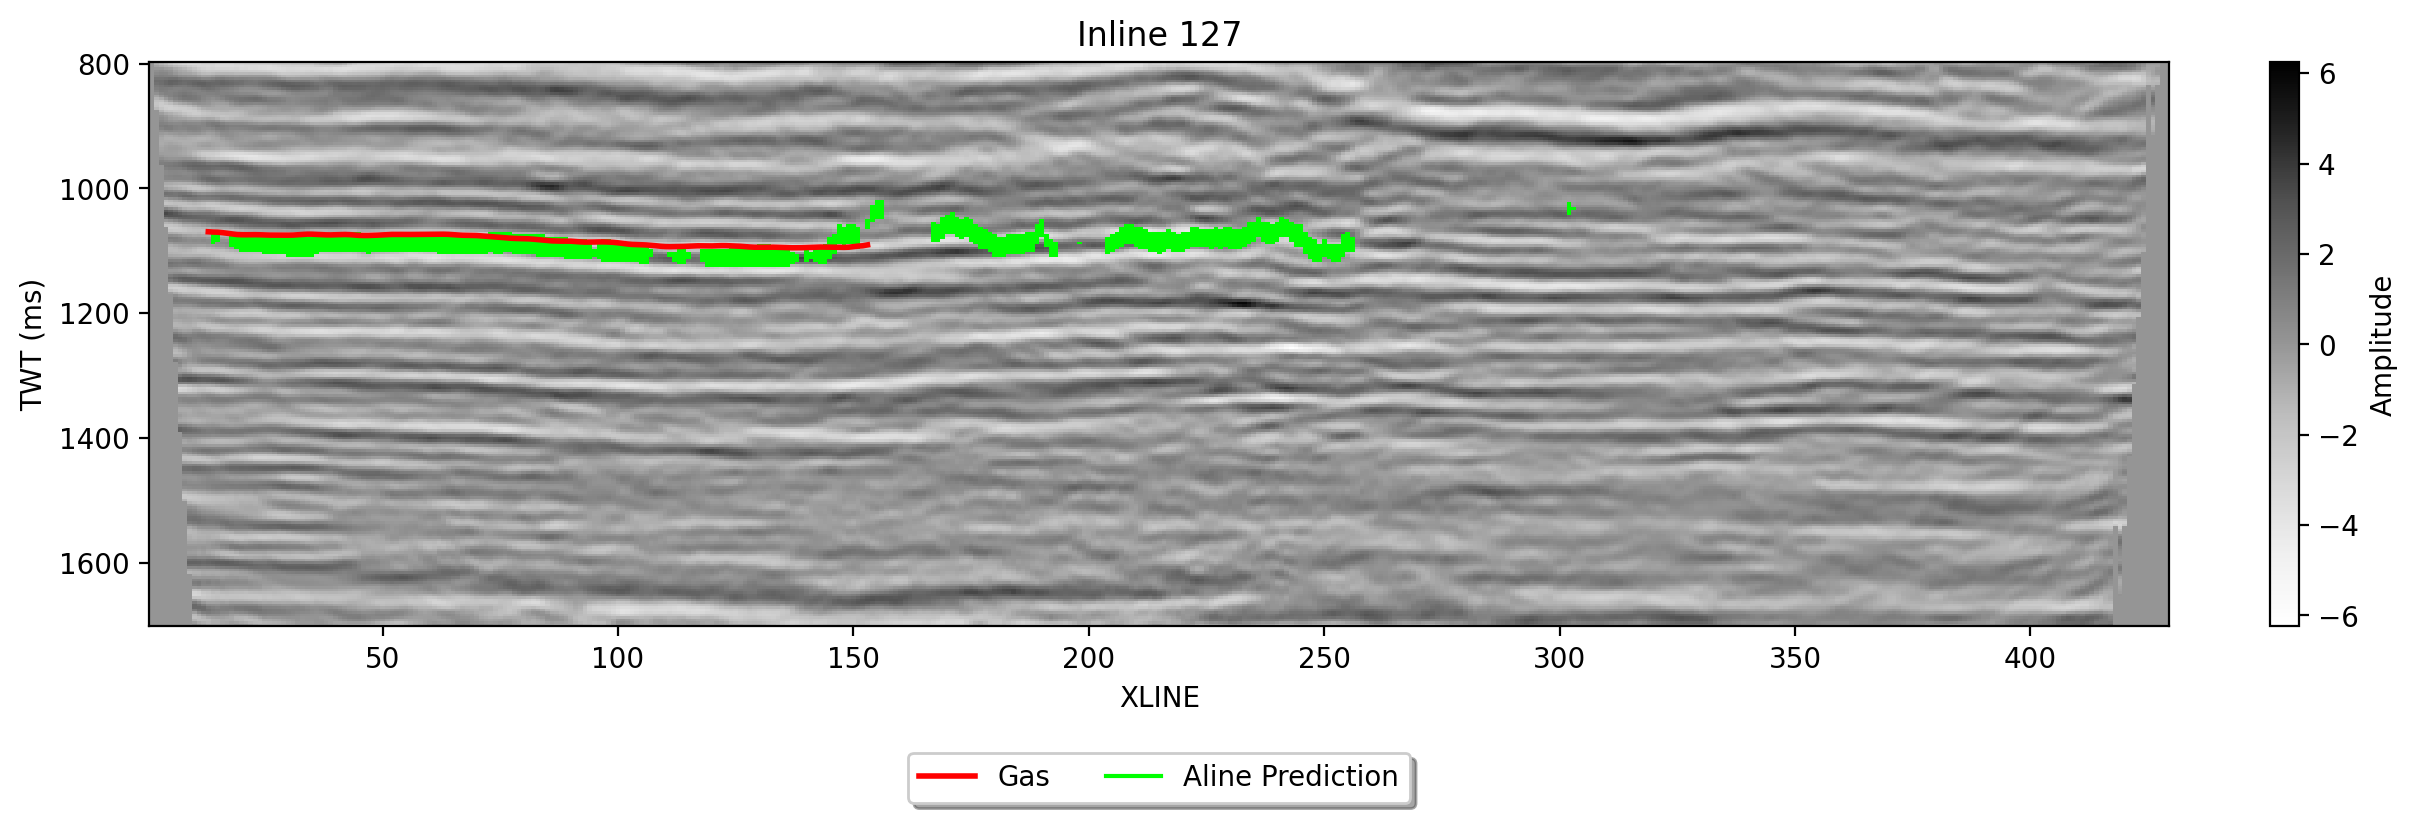

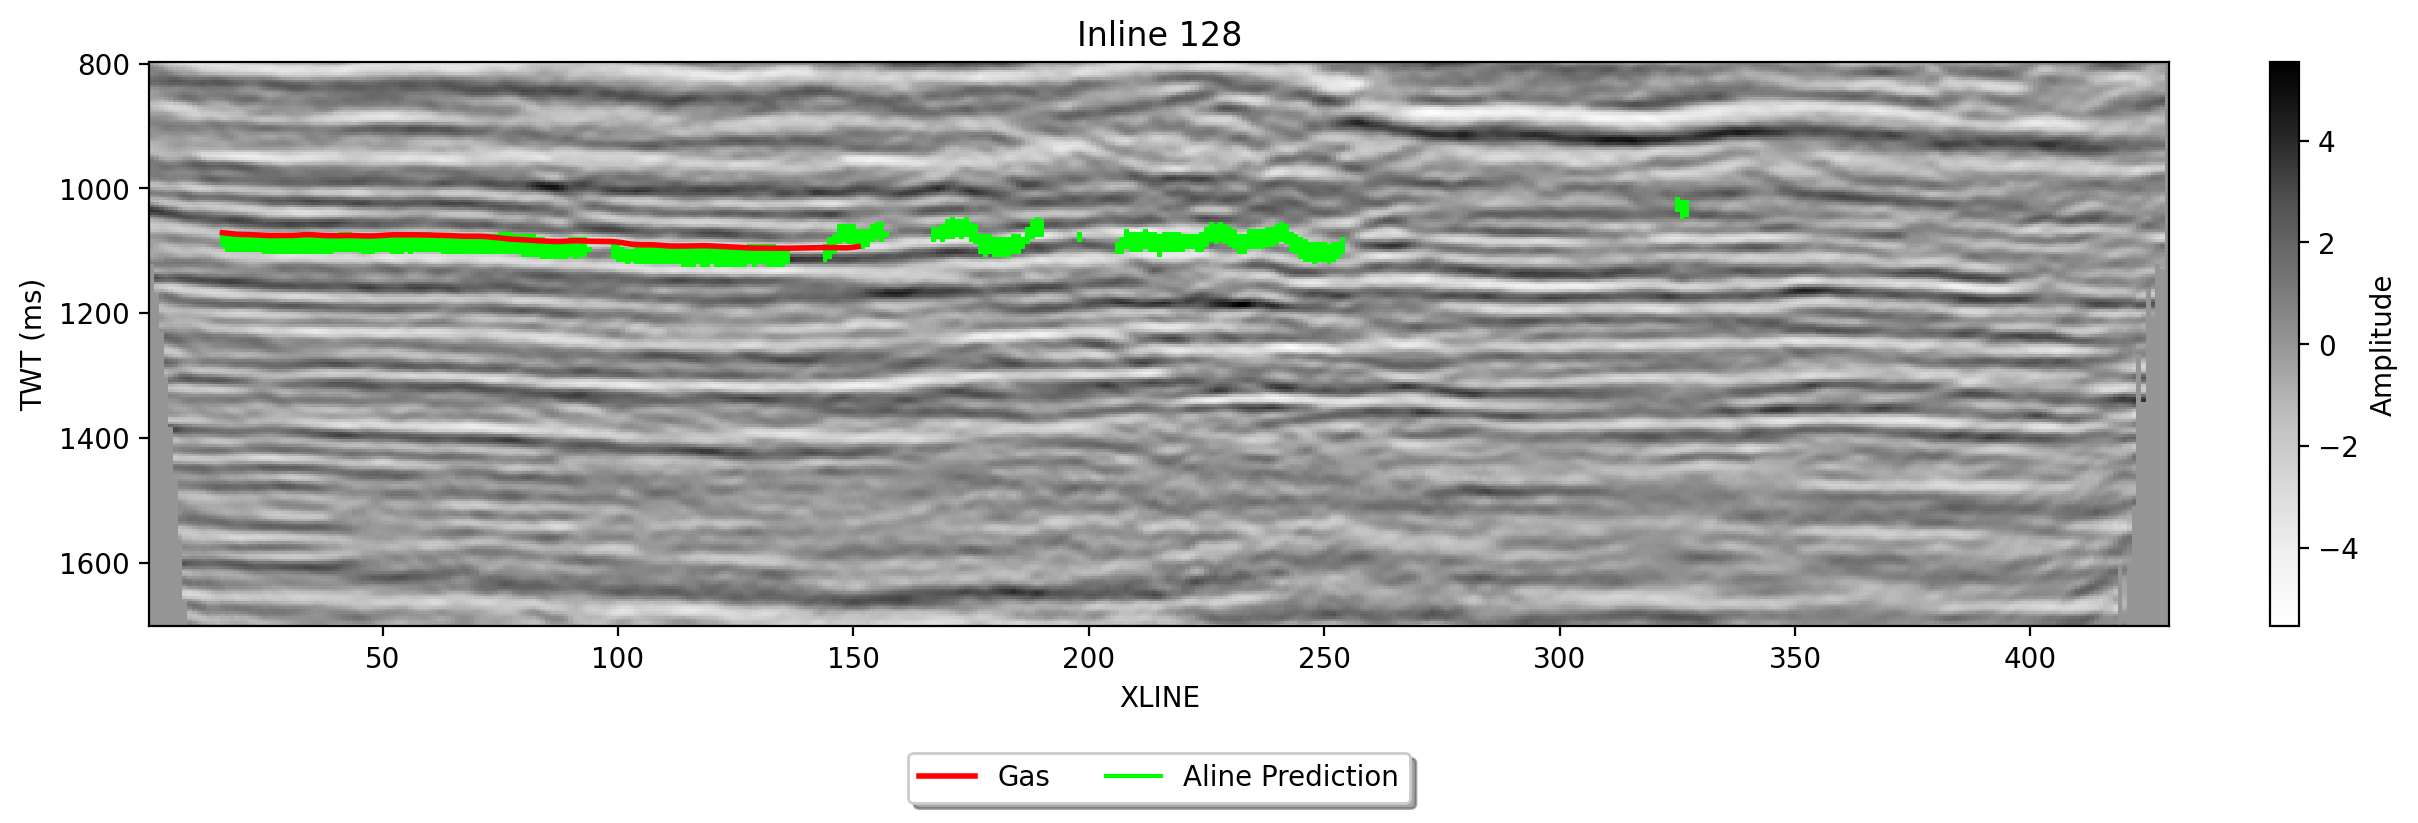

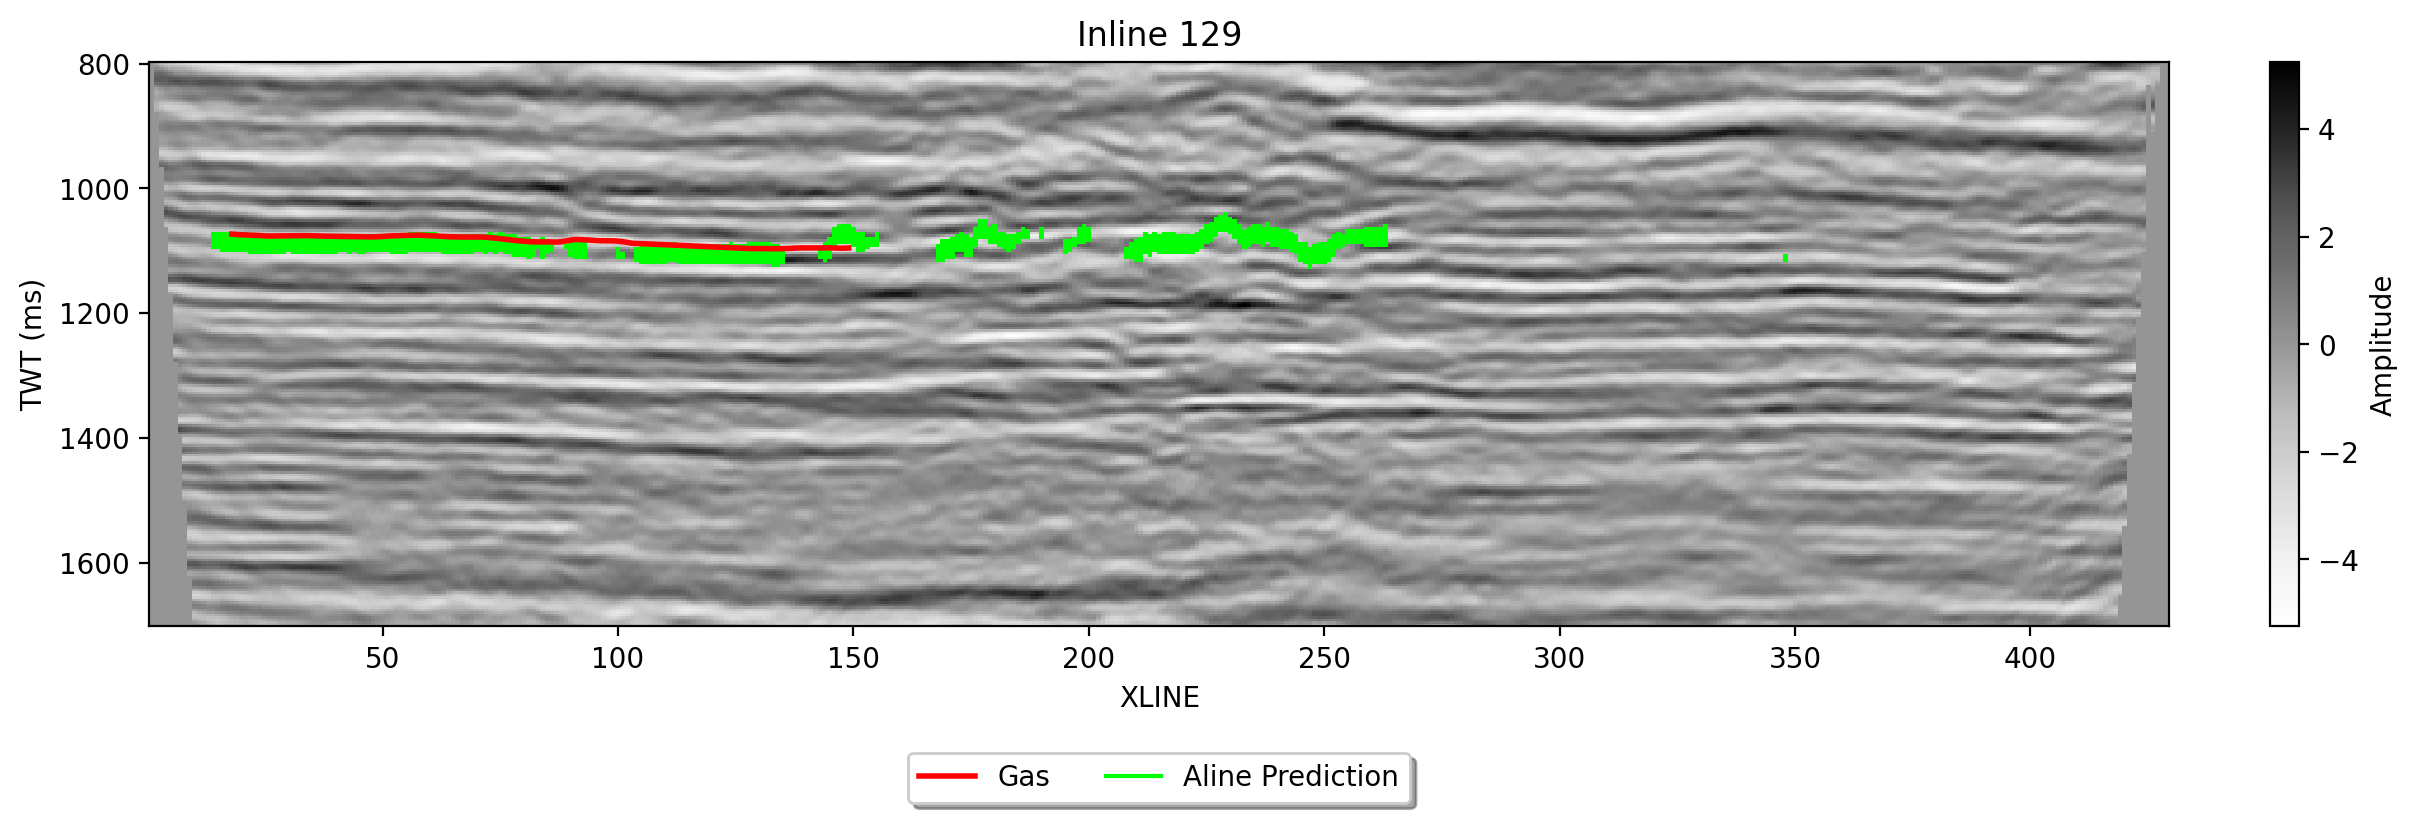

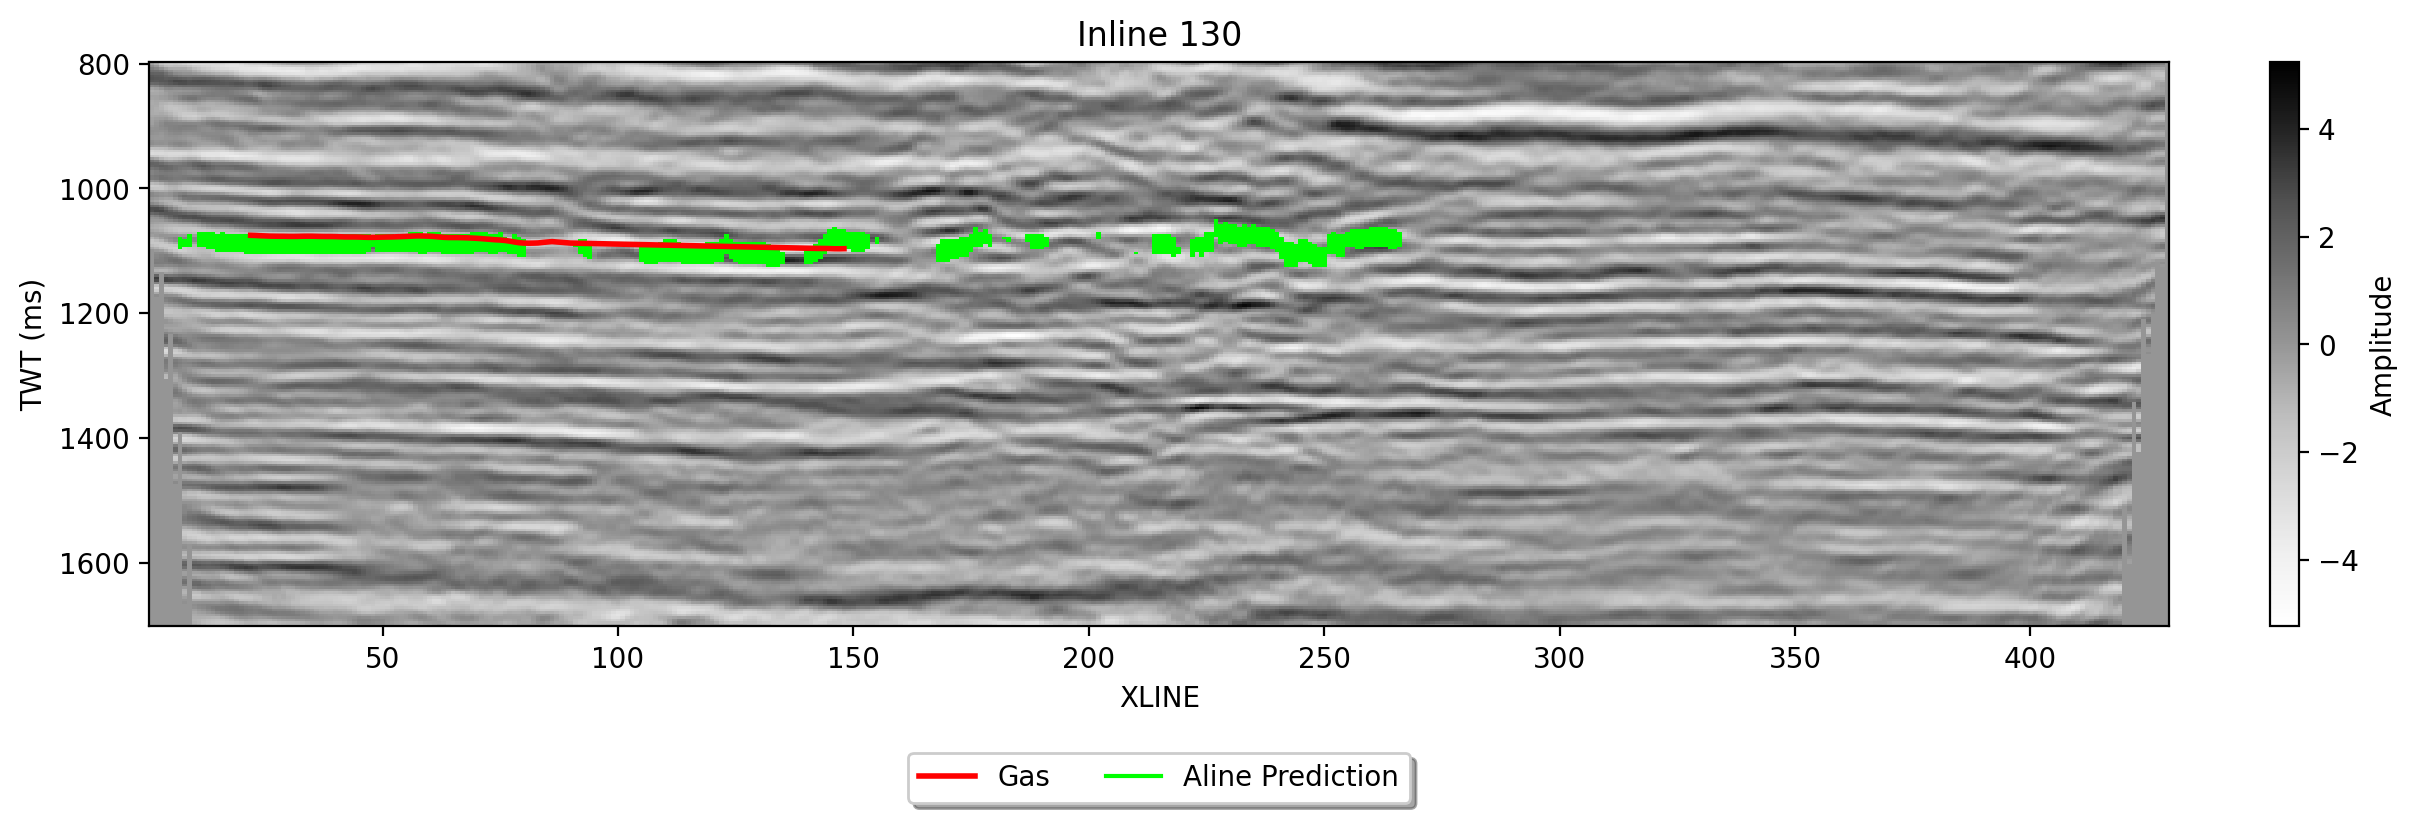

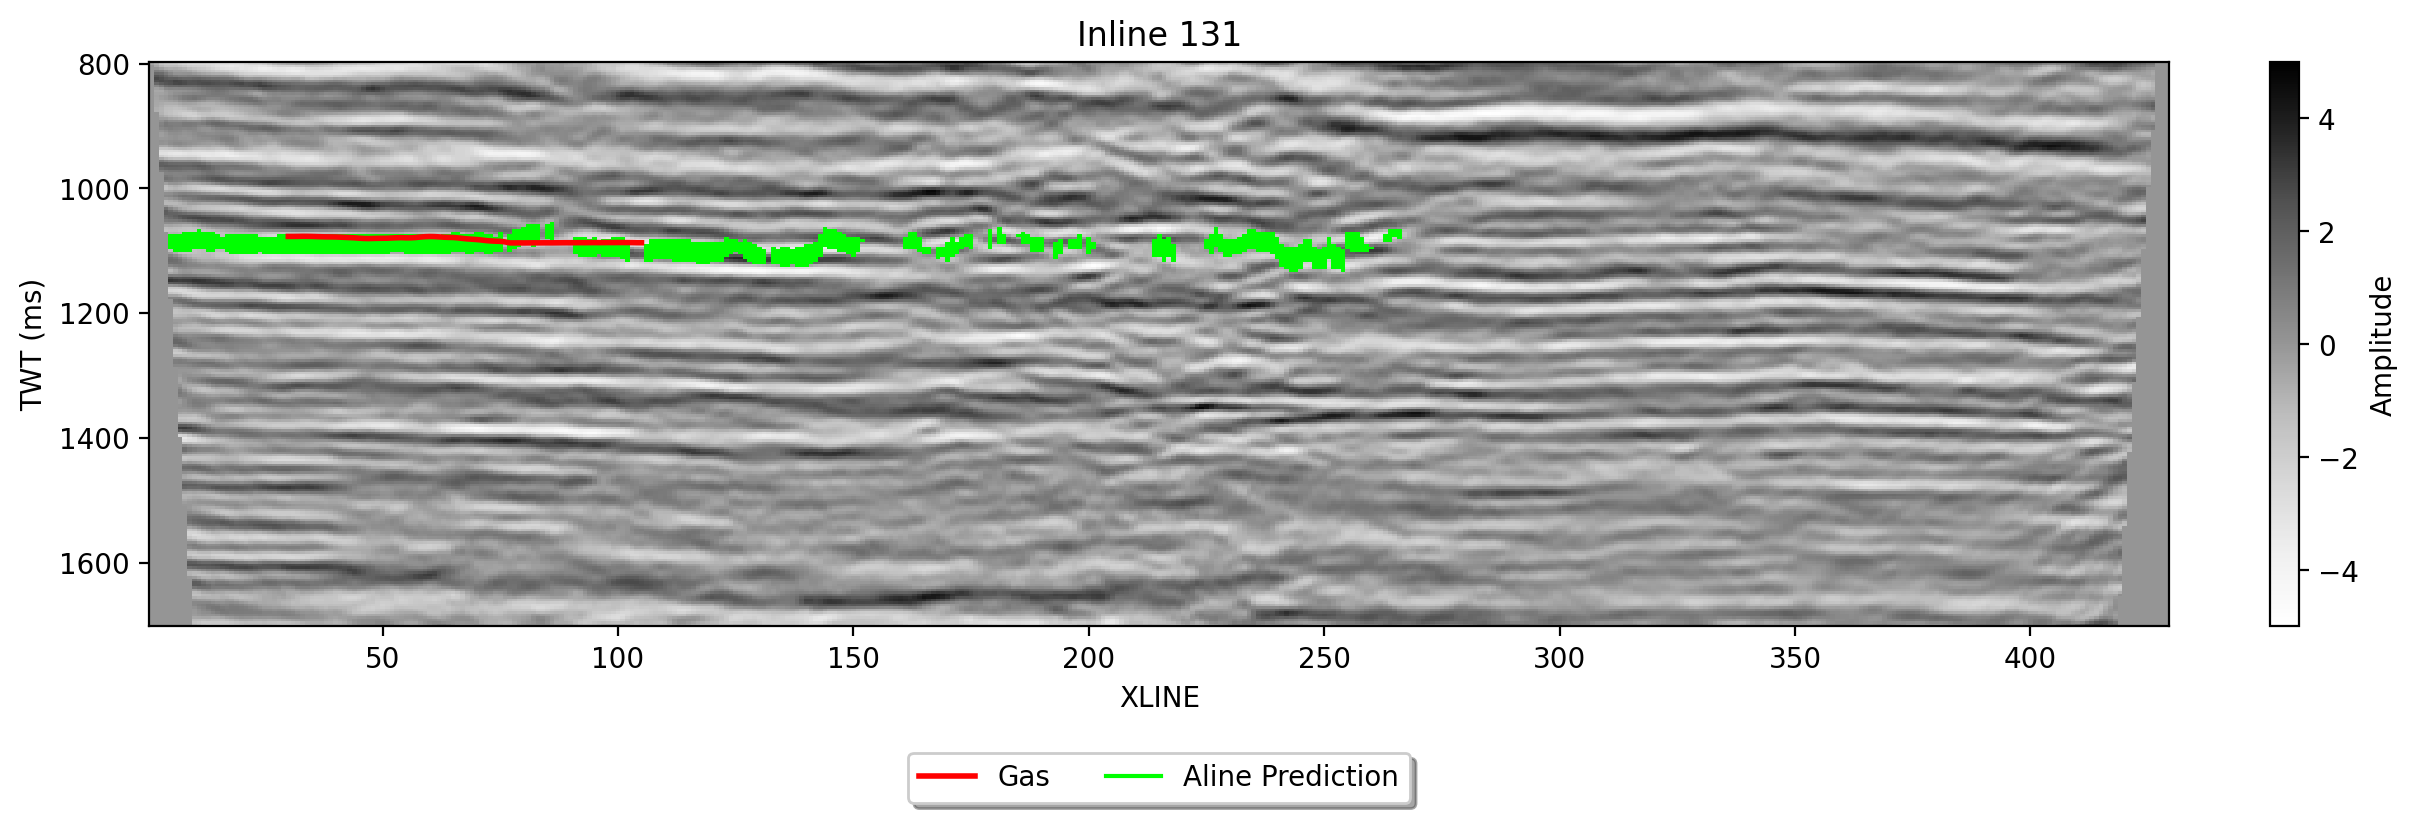

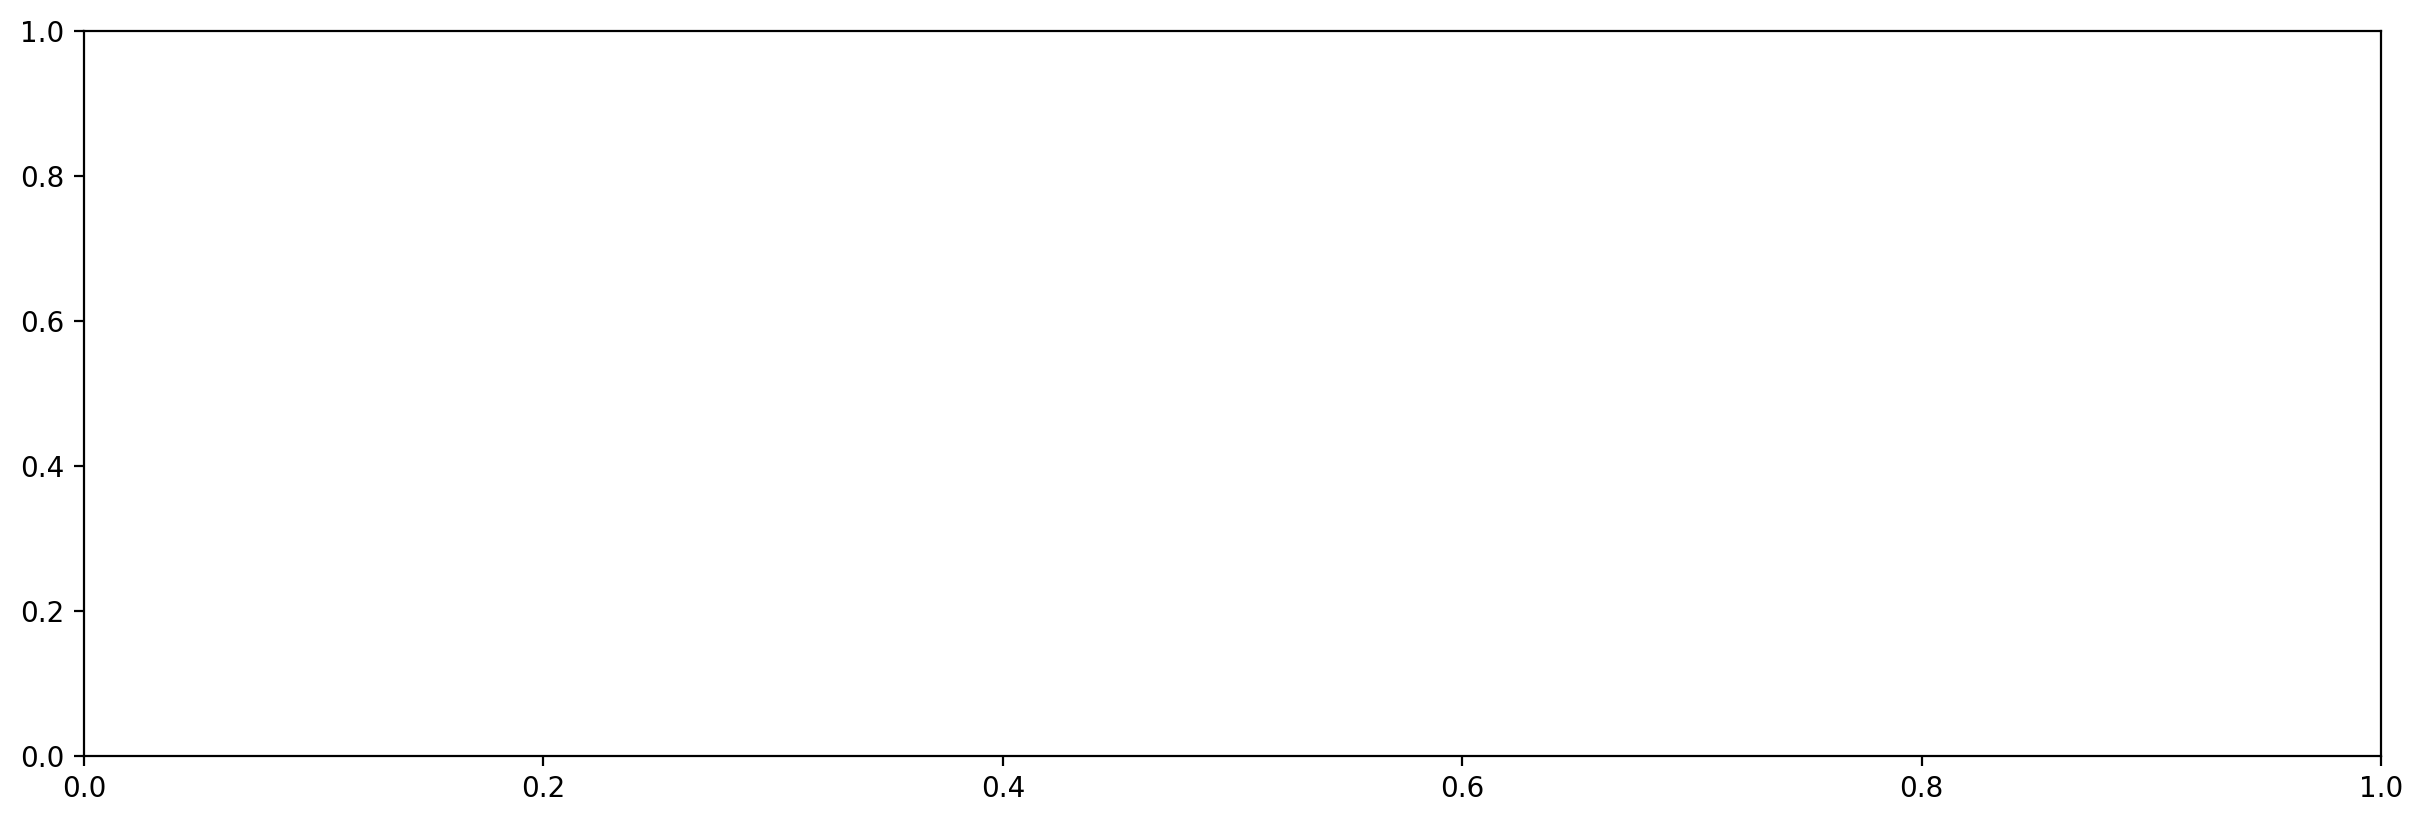

In [11]:
segy_path3D = 'uatumaFoldArticle/fold_5/SUBVOLUME-TEST_RIO_UATUMA_PSTM_2019_V1.sgy'
#segy_file3D = pathlib.Path(segy_path3D)
segy_cube3D = segy_loader(segy_path3D)

inference_path3D = 'resultArticleEage/' + 'INFERENCE_TEST_RIO_UATUMA_V1_FOLD5.sgy'
inference_cube_volume = segy_loader(inference_path3D)



slice_beg = 800
slice_end = 1700
outputdir = "plotTese/eage/fold_5/"

if not os.path.exists(outputdir):
    os.makedirs(outputdir)

# 3D Plot
roi_path = 'uatumaFoldArticle/fold_5/horizonSol/' + 'TEST_RIO_UATUMA_PSTM_2019_V1-RoI_inline.json'
gas_path = 'uatumaFoldArticle/fold_5/horizonGas/' + 'TEST_RIO_UATUMA_PSTM_2019_V1-gas_inline.json'


gas_keys = inference_cube_volume.iline  

for inlineNumber in gas_keys:

    plot_3D_visualization(segy_cube3D, 
                      inference_cube_volume, 
                      outputdir, inlineNumber, slice_beg, slice_end, roi_path, gas_path)